**Explanation**

## User-Agnostic Item Ranking Algorithm

This notebook implements a user-agnostic item ranking algorithm that aims to find a robust average rating for each item, filtering out potential outliers. The goal is to provide a reliable item ranking that is not biased by individual user variations.

### **How it Works**

1.  **Load Dataset:** The notebook begins by loading a tab-separated dataset containing user-item ratings, including a "normalized\_rating" column.
2.  **Iterate Through Items:** The algorithm then iterates through each unique item in the dataset.
3.  **Iterative Mean Filtering:** For each item, it performs an iterative process:
    * Calculate the mean and standard deviation of the item's ratings.
    * Filter out ratings that deviate significantly (more than one standard deviation) from the mean.
    * Repeat until no more ratings are filtered out (convergence).
4.  **Compute Final Ranking:** The final ranking for each item is determined by the mean of the remaining (filtered) ratings.
5.  **Visualize Results:** The notebook then creates a histogram to visualize the distribution of the calculated item rankings.

### **This notebook will:**

* Load a tab-separated dataset containing user-item ratings.
* Implement a user-agnostic item ranking algorithm.
* Generate a histogram showing the distribution of the resulting item rankings.
* Filter outliers from item ratings to get a more robust mean.

**1.  Imports**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from collections import defaultdict

**2.    Load Dataset**

In [31]:
# Define dataset path
file_path = "/home/martimsbaltazar/Desktop/tese/datasets/ml-1m/normalized_ratings.dat"

# Load dataset
df = pd.read_csv(file_path, sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp", "NormalizedRating"])

# Display first few rows
df.head()

item_raters = defaultdict(set)

for item_id, user_id in zip(df['MovieID'], df['UserID']):
    item_raters[item_id].add(user_id)


**3. User-Agnostic Bipartite ranking computation**

In [35]:
def user_agnostic_ranking(dataset, tol=1e-6):
    # Output dictionaries
    item_rankings = {}
    filtered_ratings_byItem = defaultdict(list)

    # Group by item and include user_id and normalized_rating
    grouped = dataset.groupby("MovieID")[["UserID", "NormalizedRating"]]

    for item, group in grouped:
        # Convert to list of tuples: [(user_id, rating), ...]
        user_ratings = list(zip(group["UserID"], group["NormalizedRating"]))
        converged = False

        while not converged:
            # Extract just the ratings for calculation
            ratings_only = [r for _, r in user_ratings]
            μ_i = np.mean(ratings_only)
            σ_i = np.std(ratings_only) if len(ratings_only) > 1 else 0

            # Filter and track removed
            new_user_ratings = []
            removed = []

            for uid, r in user_ratings:
                if (r - μ_i) ** 2 <= σ_i:
                    new_user_ratings.append((uid, r))
                else:
                    removed.append((uid, r))

            # Track filtered ratings
            filtered_ratings_byItem[item].extend(removed)

            # Convergence check
            converged = (len(new_user_ratings) == len(user_ratings))
            user_ratings = new_user_ratings

        # Store final ranking
        final_ratings = [r for _, r in user_ratings]
        item_rankings[item] = np.mean(final_ratings) if final_ratings else np.nan

    return item_rankings, filtered_ratings_byItem


**4.    Compute item rankings**

In [32]:
# Compute rankings using the bipartite ranking algorithm
item_rankings, filtered_ratings_byItem = user_agnostic_ranking()

print("item_rankings: ", item_rankings)

# Display top-ranked items
sorted_rankings = sorted(item_rankings.items(), key=lambda x: x[1], reverse=True)
sorted_rankings[:10]


item_rankings:  {1: 0.8475, 2: 0.640228245363766, 3: 0.603347280334728, 4: 0.5292682926829269, 5: 0.6013513513513513, 6: 0.7844492440604751, 7: 0.7018181818181819, 8: 0.6029411764705882, 9: 0.522, 10: 0.7168384879725085, 11: 0.764774951076321, 12: 0.4447368421052632, 13: 0.6525252525252525, 14: 0.7186666666666666, 15: 0.4661870503597123, 16: 0.7644444444444445, 17: 0.8313527180783816, 18: 0.6926174496644295, 19: 0.46301369863013697, 20: 0.5075000000000001, 21: 0.7342342342342342, 22: 0.6919667590027702, 23: 0.5714285714285715, 24: 0.6358974358974359, 25: 0.7605177993527508, 26: 0.7270833333333333, 27: 0.5868852459016394, 28: 0.8302325581395347, 29: 0.8248101265822784, 30: 0.7444444444444444, 31: 0.6226950354609928, 32: 0.79744966442953, 33: 0.6000000000000001, 34: 0.7984633569739953, 35: 0.6695652173913043, 36: 0.7954446854663774, 37: 0.7, 38: 0.5642857142857143, 39: 0.7425968109339408, 40: 0.7866666666666668, 41: 0.8184210526315789, 42: 0.5737556561085972, 43: 0.7012345679012344, 44: 

[(787, 1.0),
 (989, 1.0),
 (1420, 1.0),
 (1830, 1.0),
 (3172, 1.0),
 (3233, 1.0),
 (3280, 1.0),
 (3382, 1.0),
 (3607, 1.0),
 (3656, 1.0)]

**5. Visualizing the Distribution of Item Rankings**

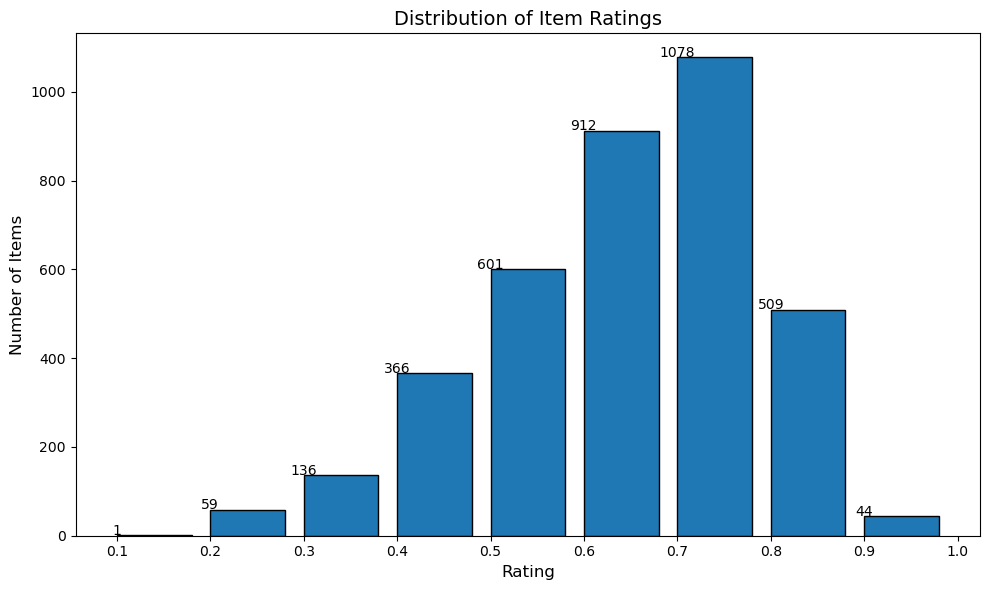

In [33]:
# Extract the ratings from the rankings
ratings = list(item_rankings.values())

# Define bins for the ratings (from 0.1 to 1.0 with steps of 0.1)
bins = np.arange(0.1, 1.1, 0.1)

# Count how many items fall into each rating bin
hist, bin_edges = np.histogram(ratings, bins=bins)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(hist)):
    plt.text(bin_edges[i], hist[i] + 1, str(hist[i]), ha='center', fontsize=10)

# Finalize the plot
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.title('Distribution of Item Ratings', fontsize=14)
plt.xticks(bins)  # Ensure the x-ticks correspond to the rating bins
plt.tight_layout()
plt.show()


**6. Demographics**

In [15]:
from collections import defaultdict

# Define age ranges with lambda checks
age_ranges = {
    "< 18": lambda age: age < 18,
    "18-24": lambda age: 18 <= age <= 24,
    "25-34": lambda age: 25 <= age <= 34,
    "35-44": lambda age: 35 <= age <= 44,
    "45-54": lambda age: 45 <= age <= 54,
    ">= 55": lambda age: age >= 55,
}

# Initialize dictionaries with sets as default values
gender_groups = defaultdict(set)
age_groups = defaultdict(set)

file_path = "/home/martimsbaltazar/Desktop/tese/datasets/ml-1m/users.dat"

with open(file_path, 'r') as file:
    for line in file:
        # Strip newline and split using the '::' delimiter
        parts = line.strip().split("::")
        if len(parts) != 5:
            continue  # Skip malformed lines

        user_id, gender, age_str, _, _ = parts

        user_id = int(user_id)
        age = int(age_str)

        # Match age to a range label
        for label, condition in age_ranges.items():
            if condition(age):
                age_groups[label].add(user_id)
                break  # Stop once matched

        # Gender grouping
        gender_groups[gender].add(user_id)

# Example: Print sizes of each group
print(f"Gender Groups: {gender_groups}") 

print(f"\nAge Groups: {age_groups}")


Gender Groups: defaultdict(<class 'set'>, {'F': {1, 6, 10, 11, 16, 18, 24, 28, 30, 32, 34, 37, 38, 41, 45, 50, 51, 55, 59, 62, 67, 69, 72, 75, 78, 79, 81, 83, 86, 88, 89, 92, 96, 97, 98, 99, 101, 106, 114, 119, 122, 127, 133, 137, 139, 140, 146, 151, 156, 159, 162, 164, 167, 168, 171, 175, 176, 183, 184, 187, 193, 194, 196, 200, 201, 203, 210, 213, 219, 221, 224, 233, 238, 242, 246, 249, 253, 262, 263, 265, 268, 277, 281, 285, 288, 289, 290, 294, 298, 305, 310, 312, 313, 314, 315, 318, 319, 325, 334, 340, 341, 343, 346, 347, 353, 358, 361, 364, 365, 372, 373, 374, 378, 379, 382, 383, 387, 388, 399, 400, 410, 411, 415, 417, 418, 421, 428, 430, 434, 446, 447, 455, 459, 464, 467, 468, 470, 473, 475, 480, 484, 487, 494, 497, 499, 500, 507, 511, 516, 517, 518, 519, 520, 527, 528, 531, 541, 546, 548, 556, 559, 561, 568, 569, 573, 576, 583, 584, 588, 590, 593, 594, 596, 601, 602, 603, 605, 606, 617, 619, 625, 628, 629, 630, 634, 641, 642, 648, 655, 656, 657, 658, 659, 663, 666, 668, 687, 689,

**6. Metrics**


**6.1 Effectiveness**

In [59]:
def compute_aggregated_average_ranking(df):
    return df.groupby("MovieID")["NormalizedRating"].mean().to_dict()

def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Ensure only common items are compared

    if len(common_items) < 2:  # Need at least two rankings to compute Kendall's tau
        return 0
    
    sorted_items = sorted(common_items)  # Sort items to ensure consistent order
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

# Compute the aggregated average ranking
aa_rankings = compute_aggregated_average_ranking(df)

# Compute Kendall’s tau for the entire dataset
tau_value = compute_kendall_tau(item_rankings, aa_rankings)
print(f"Kendall’s τ: {tau_value:.4f}")



Kendall’s τ: 0.9542


**6.2   Bias**

In [17]:
def compute_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem):
    """
    Compute B(i) for each item, which is the difference between P_complement(i) and P(i).
    """
    retention_rates = {}

    # Get the users in the demographic group
    target_users = demographic_group[restriction]
    for item, users_who_rated in item_raters.items():
        # Users from the target group who rated the item
        U_i = len(users_who_rated & target_users)        

        # Users from the target group whose ratings got filtered
        filtered_users = {uid for uid, _ in filtered_ratings_byItem.get(item, [])}

        R_i = U_i - len(filtered_users & target_users)  # Retained ratings
        
        # Compute P(i)
        P_i = R_i / U_i if U_i > 0 else 0

        # Compute the complement group (all other users that rated the item but are not in the target group)
        non_target_users = users_who_rated - target_users

        U_complement_i = len(non_target_users)
        R_complement_i = U_complement_i - len(filtered_users & non_target_users)
        

        # Compute P_complement(i)
        P_complement_i = R_complement_i / U_complement_i if U_complement_i > 0 else 0
        
        # Compute B(i) = P_complement(i) - P(i)
        B_i =  abs(P_i - P_complement_i)

        # Store results
        retention_rates[item] = {
            "P(i)": P_i,
            "P_complement(i)": P_complement_i,
            "B(i)": B_i
        }

    return retention_rates

def compute_mean_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem):
    """
    Compute B(g) (mean bias) for a given demographic group.
    """
    bias_results = compute_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem)
    # Sum all B(i) values
    total_bias = sum(item_data["B(i)"] for item_data in bias_results.values())

    # Compute B(g)
    B_g = total_bias / len(bias_results) if bias_results else 0  # Avoid division by zero

    return B_g, bias_results

print("--------------------- AGE_GROUPS ---------------------")

bg, results = compute_mean_bias("< 18", age_groups, item_raters, filtered_ratings_byItem)
print("< 18: ", bg)
bg, results = compute_mean_bias("18-24", age_groups, item_raters, filtered_ratings_byItem)
print("18-24: ", bg)
bg, results = compute_mean_bias("25-34", age_groups, item_raters, filtered_ratings_byItem)
print("25-34: ", bg)
bg, results = compute_mean_bias("35-44", age_groups, item_raters, filtered_ratings_byItem)
print("35-44: ", bg)
bg, results = compute_mean_bias("45-54", age_groups, item_raters, filtered_ratings_byItem)
print("45-54: ", bg)
bg, results = compute_mean_bias(">= 55", age_groups, item_raters, filtered_ratings_byItem)
print(">= 55: ", bg)

print("\n--------------------- CONTINENT ---------------------")
bg, results = compute_mean_bias("F", gender_groups, item_raters, filtered_ratings_byItem)
print("Female: ", bg)
bg, results = compute_mean_bias("M", gender_groups, item_raters, filtered_ratings_byItem)
print("Male: ", bg)



--------------------- AGE_GROUPS ---------------------
< 18:  0.31888310988502444
18-24:  0.12704431046001471
25-34:  0.08231172517242363
35-44:  0.09384116546872756
45-54:  0.09839283971602542
>= 55:  0.24237236811487328

--------------------- CONTINENT ---------------------
Female:  0.09246290335857978
Male:  0.09246290335857978


**6.3   Robustness**

In [60]:
import os

# Directory where your spam-injected files are located
spam_dir = "/home/martimsbaltazar/Desktop/tese/datasets/ml-1m/spam_versions"

# Spam ratios you want to evaluate
ratios = [10, 30, 50, 70]
i = 0

while i < len(ratios):
    percent = ratios[i]
    file_name = f"ratings_with_{percent}percent_spam.csv"
    file_path = os.path.join(spam_dir, file_name)

    # Load the dataset
    df_attack = pd.read_csv(file_path)
    df_attack.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp', 'NormalizedRating']

    # Compute rankings using your bipartite ranking algorithm
    item_rankingsSpam, filtered_ratings_byItem = user_agnostic_ranking(df_attack)

    # Compute Kendall's tau
    tau_value = compute_kendall_tau(item_rankings, item_rankingsSpam)

    # Print the result
    print(f"[{percent}% Spam] Kendall’s τ: {tau_value:.4f}")
    
    i += 1




[10% Spam] Kendall’s τ: 0.9882
[30% Spam] Kendall’s τ: 0.9708
[50% Spam] Kendall’s τ: 0.9589
[70% Spam] Kendall’s τ: 0.9451
